# Switching System
_Author:_ Grégoire Pacreau, Pietro Novelli

In this example we show how `kooplearn` can be used to analyze the behaviour of a switching system, validating our results with Fourier theory. We study a simple signal composed by a sum of a small number of sinusoidal functions. These signals are easily analyzed using Fourier theory, but similar results can be obtained via Koopman theory and its implementation in `kooplearn`. In particular, we show that how to recover changes in the signal by detecting changes in the underlying process. Here, this will be modeled by a sudden change of the dominant frequencies of the signal during a _switching_ period.

### Data generation 

In the following we define a function generating a purely oscillatory linear dynamical system with given frequencies.

In [1]:
import numpy as np
import scipy


def make_oscillatory_matrix(frequencies, dt=1.0):
    blocks = []
    for f in frequencies:
        if f < 0:
            raise ValueError("Frequencies must be non-negative.")
        omega = 2 * np.pi * f
        theta = omega * dt
        rotation_matrix = np.array(
            [[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]]
        )
        blocks.append(rotation_matrix)

    return scipy.linalg.block_diag(*blocks)

We can now create our signal. The signal in the first (fast) regime has frequencies 10Hz and 13Hz. The signal in the second (slow) regime has frequencies 2Hz and 3Hz.

In [2]:
from kooplearn.datasets import make_regime_switching_var

dt = 0.01
n_steps = 2000
noise = 0.001
fast_frequencies = [10, 13]
fast_phi = make_oscillatory_matrix(fast_frequencies, dt=dt)
slow_frequencies = [2, 3]
slow_phi = make_oscillatory_matrix(slow_frequencies, dt=dt)
regime_transition_matrix = np.array([[0.99, 0.01], [0.005, 0.995]])
# Initial state
X0 = 0.1 * np.ones(slow_phi.shape[0])

X = make_regime_switching_var(
    X0,
    fast_phi,
    slow_phi,
    regime_transition_matrix,
    n_steps=n_steps,
    noise=noise,
    dt=dt,
    random_state=0
)
y = X.values.sum(axis=1) # Sum the states into a single signal
times = X.index.get_level_values("time")
regimes = X.attrs['regimes']
fast_y = np.ma.masked_where(regimes == 1, y)
slow_y = np.ma.masked_where(regimes == 0, y)

Let's plot the trajectories of our dataset

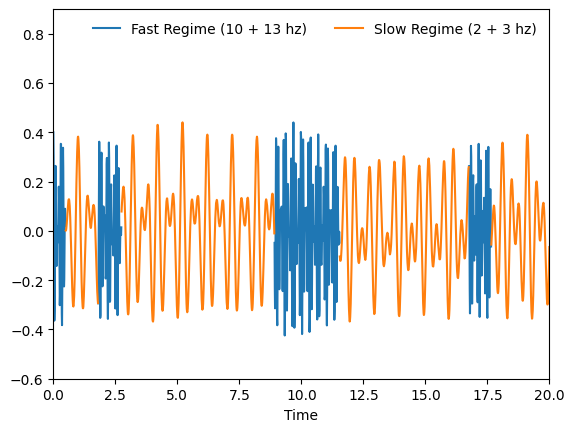

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(times, fast_y, label="Fast Regime (10 + 13 hz)")
ax.plot(times, slow_y, label="Slow Regime (2 + 3 hz)")
ax.legend(frameon=False, ncols=2)
ax.set_xlabel("Time")
ax.set_ylim(-0.6, 0.9)
ax.margins(0)

Let us verify that we do recover those frequencies using the classical Fourier spectrogram as implemented in ``scipy.signal``.

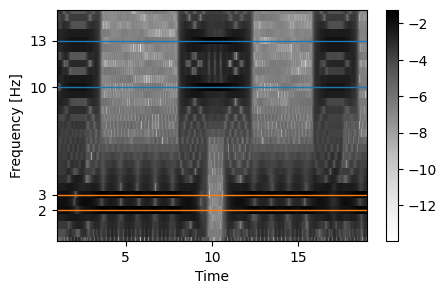

In [4]:
from scipy import signal

n_seg = 200
res_spectrogram = signal.spectrogram(
    y, dt**-1, scaling="density", nperseg=n_seg, noverlap=n_seg - 1
)

fig, ax = plt.subplots(figsize=(5, 3))
pcolor = ax.pcolormesh(
    res_spectrogram[1], res_spectrogram[0], np.log10(res_spectrogram[2]), cmap="Greys"
)
ax.set_ylabel("Frequency [Hz]")
ax.set_xlabel("Time")
ax.set_yticks(fast_frequencies + slow_frequencies)
ax.set_ylim(0, 15)
for f in slow_frequencies:
    ax.axhline(y=f, color="tab:orange", lw=1)
for f in fast_frequencies:
    ax.axhline(y=f, color="tab:blue", lw=1)
fig.colorbar(pcolor)

### Fitting the Kooplearn model

In [5]:
from kooplearn.kernel import KernelRidge
from kooplearn.preprocessing import TimeDelayEmbedding

We use a time delay embedding with 5 snapshots of history to fit the Koopman operator model.

In [6]:
td = TimeDelayEmbedding(history_length=5).fit(X)
model = KernelRidge(
    n_components=24, kernel="rbf", alpha=1e-6, gamma=0.1, eigen_solver="arpack"
).fit(td.transform(X))

In [7]:
dynamical_modes = model.dynamical_modes(td.transform(X))
dynamical_modes.summary(dt=dt).head(5)

,frequency,lifetime,eigenvalue_real,eigenvalue_imag,eigenvalue_magnitude,is_stable,is_conjugate_pair
0,0.000000,9132.375181,0.999999,0.000000,0.999999,True,False
1,3.014476,9.884760,0.981123,-0.188084,0.998989,True,True
2,2.013758,9.684646,0.990982,-0.126061,0.998968,True,True
3,12.947025,1.952708,0.683461,-0.722974,0.994892,True,True
4,9.960750,1.944084,0.806306,-0.582783,0.994869,True,True


Note that we have found modes around 13, 10, 3, and 2 Hz, as expected. The slow modes (low frequency) have a longer lifetime than the fast frequency ones, as expected. Indeed, the switching from slow to fast regime is governed by a geometric distribution with parameter $p$ given by  `regime_transition_matrix[1, 0] = 0.005` while  switching from fast to slow will be `regime_transition_matrix[0, 1] = 0.01`.

Text(0.5, 0, 'Time')

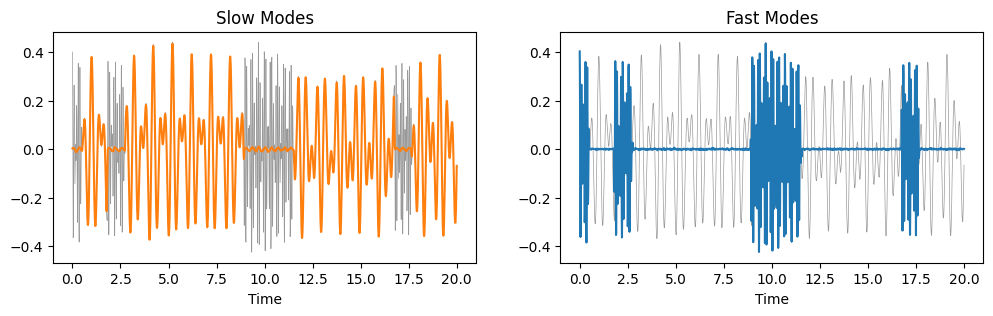

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 3))
# We invert the time delay embedding to have the dynamical modes only for the true dynamical state.
slow_modes = (td.inverse_transform(dynamical_modes[1]) +
              td.inverse_transform(dynamical_modes[2])).sum(axis=-1)
fast_modes = (td.inverse_transform(dynamical_modes[3]) +
              td.inverse_transform(dynamical_modes[4])).sum(axis=-1)
axs[0].plot(times, y, color="k", lw=0.5, alpha=0.4)
axs[0].plot(times, slow_modes, color="tab:orange")
axs[0].set_title("Slow Modes")
axs[0].set_xlabel("Time")

axs[1].plot(times, y, color="k", lw=0.5, alpha=0.4)
axs[1].plot(times, fast_modes, color="tab:blue")
axs[1].set_title("Fast Modes")
axs[1].set_xlabel("Time")

As we can see, the dynamical models associated to the low frequencies perfectly capture the "slow regime", and vanish in the fast regime. Similarly, the high-frequency modes lights up in the fast regime, and are none elsewhere. Koopman dynamical modes, therefore, automatically identify the different regimes and can be leveraged —  for example taking their expected value over short time windows —  to detect regime switching.